# Test EV control

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from ev_ssm import ev_ssm
from tqdm import tqdm
import scipy.stats as stats

In [2]:
# manually search perceptron hyperparameters for binary classification
import cProfile as profile
import pstats

In [3]:
sse0 = ev_ssm(ts=18, N=50000, step=1, tp=40,
              lr=0.1, lp=40, seed=2022, name="EVA",
              n_pref=1, is_report=True,
              tt_mean=0.5, tt_var=0.2, tt_lb=0, tt_ub=1,
              ict=True, ecc=True)
sse0.load_A("Aest.csv")


EVA: ts=18[H], 50000 EVs, Total Q=434.54 MWh
Online 14477, Q=362.27 MWh, SoC=0.7435
Power(MW): Pt=-39.0266, Pc=-39.0266, Pd=-0.0
Ctrl: 0=7897; 1=6580; 
EVA: Load A from Aest.csv.


In [4]:
sse0.ev['nam'].max()

3946

In [22]:
self = sse0

pcn = self.ev['Pc'].mean() * self.ev['nc'].mean()
self.ev['nam'] = ((self.ev['tf'].mean() - self.ev['ts'].mean() + self.ev['tt']) * pcn
                  - self.ev['socd'] * self.ev['Q']) * 3600 / (pcn * self.config['t_agc'])
self.ev['nam'] = self.ev['nam'].astype(int)
self.ev['nam'].max()

4471

<AxesSubplot:>

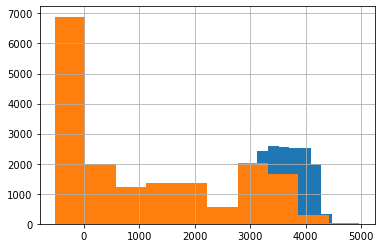

In [23]:
sse0.ev['nam'].hist()
sse0.ev['na'].hist()

In [ ]:
# --- Response ---
from ev_ssm import ev_ssm
import numpy as np

sse = ev_ssm(ts=18, N=50000, step=1, tp=40,
             lr=0.1, lp=40, seed=2022, name="EVA",
             n_pref=1, is_report=True,
             tt_mean=0.5, tt_var=0.2, tt_lb=0, tt_ub=1,
             ict=False, ecc=True)
sse.load_A("Aest.csv")

evd0 = sse.ev.copy()

# quiet some EVs by force
# np.random.seed(sse.config["seed"])
# ict_rid = np.random.randint(low=0,
#                             high=sse.ev.shape[0],
#                             size=3000)

# sse.ev.na.iloc[ict_rid] = sse.ev.nam.iloc[ict_rid]
# sse.ev.lc.iloc[ict_rid] = 1
# sse.g_u()

# initial EV data
evd0 = sse.ev.copy()

sse.g_frc()


In [ ]:
sse.run(tf=18 + 40/3600, Pi=50,
        is_updateA=False, is_rstate=True,
        is_test=False, disable=True)

for i in range(10):
        sse.run(tf=18 + (40 + i)/3600, Pi=50,
                is_updateA=False, is_rstate=True,
                is_test=False, disable=True)

In [ ]:
sse.plot_agc()

In [ ]:
sse.plot_agc()

In [ ]:
sse.run(tf=18 + 50/3600, Pi=50,
        is_updateA=False, is_rstate=True,
        is_test=False, disable=True)

In [ ]:
sse.plot_agc()

In [ ]:
col = ["u", "c", "tf", "agc", "soci", "soc0", "soc", "socd", "na", "nam"]
sse.ev[col]
sse.ev[col][sse.ev['agc'] != 0]

In [ ]:
sse.plot_agc()

In [ ]:
prof = profile.Profile()
prof.enable()
for i in range(20):
        sse.run(tf=18 + i/3600, Pi=0.5*i,
                is_updateA=False, is_rstate=True,
                is_test=False, disable=True)
for i in range(20):
        sse.run(tf=18 + (20 + i)/3600, Pi=10 - 0.5*i,
                is_updateA=False, is_rstate=True,
                is_test=False, disable=True)
prof.disable()

In [ ]:
sse.plot_agc()

In [ ]:
import time
tl = []
n = 10000
for i in range(n):
    t0 = time.time()
    idx = sse.ev[(sse.ev["u"].values == 1) & (sse.ev["c"] == 1)].index
    t = time.time() - t0
    tl.append(t)
print("n=", n, "mean[ms]=", 1e3 * np.mean(tl).round(4), "std[ms]=", 1e3*np.std(tl).round(4))

In [ ]:
import time
tl = []
n = 100
for i in range(n):
    Pi = 5 + np.random.uniform(low=-4, high=4, size=1)[0]
    t0 = time.time()
    sse.r_agc(Pi)
    t = time.time() - t0
    tl.append(t)
print("n=", n, "mean=", np.mean(tl).round(4), "std=", np.std(tl).round(4))

In [ ]:
stats = pstats.Stats(prof).strip_dirs().sort_stats("tottime")
stats.print_stats(20)